## SMS: Spam or Ham

Wikipedia describes Spam as “the use of electronic messaging systems to send unsolicited bulk messages, especially advertising, indiscriminately.”

According to Wiktionary Ham is “Message that is generally desired and isn't considered spam.”

The dataset contains text of 5572 SMS messages and a label, classifying the message as "spam" or "ham".
Here we explore some common techniques of NLP like:

* Removing Punctuation and Stopwords
* Tokenizer, Bag of words
* Term frequency inverse document frequency (TFIDF)


Based on these preprocessing, we train 6 different models that classify unknown messages as spam or ham.

* Naive Bayes Classifier
* SVM Classifier
* KNN Classifier
* SGD Classifier
* Gradient Boosting Classifier
* XGBoost Classifier

For easier handling of the preprocessing steps (for train and test data) and the optimization of different
models for the same conditions, the classification is done with Pipelines including GridSearchCV.
Finally, for the model evaluation different metrics are examined:
accuracy, precision, recall, fscore, roc_auc.

## Part 0: Imports, define functions

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import wordcloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
import os
print(os.listdir("."))

['.git', '.ipynb_checkpoints', 'LICENSE', 'NLP.ipynb', 'README.md', 'spam.csv']


## function

print Classification Report and Accuracy

In [4]:
def print_validation_report(y_true, y_pred):
    print("Classification Report")
    print(classification_report(y_true, y_pred))
    acc_sc = accuracy_score(y_true, y_pred)
    print("Accuracy : "+ str(acc_sc))
    
    return acc_sc

plot_confusion_matrix

In [5]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    #fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  
                cmap="Blues", cbar=False, ax=ax)
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Part 1: EDA

In [6]:
data = pd.read_csv("./spam.csv",encoding='ISO-8859-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
data = pd.read_csv("./spam.csv",encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Columns 2,3,4 contain no important data and can be deleted.
Also, we rename column v1 as "label" and v2 as "text"

In [8]:
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v1":"label", "v2":"text"})

In [9]:
data.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [10]:
data.groupby("label").describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

In [11]:
data.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

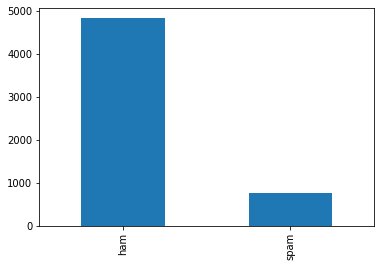

In [12]:
data.label.value_counts().plot.bar()

## Add numerical label for spam
Target must be numerical for ML classification models

In [13]:
data['spam'] = data['label'].map( {'spam': 1, 'ham': 0} ).astype(int)
data.head()

,label,text,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [14]:
data['length'] = data['text'].apply(len)
data.head()

,label,text,spam,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


(-40, 950)

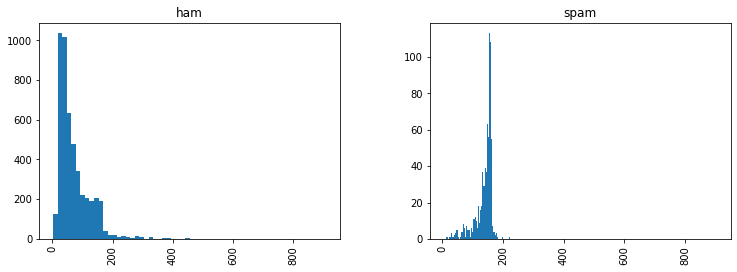

In [15]:
data.hist(column='length',by='label',bins=60,figsize=(12,4))
plt.xlim(-40,950)

In [16]:
data_ham  = data[data['spam'] == 0].copy()
data_spam = data[data['spam'] == 1].copy()


## wordclouds

In [17]:
def show_wordcloud(data_spam_or_ham, title):
    text = ' '.join(data_spam_or_ham['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

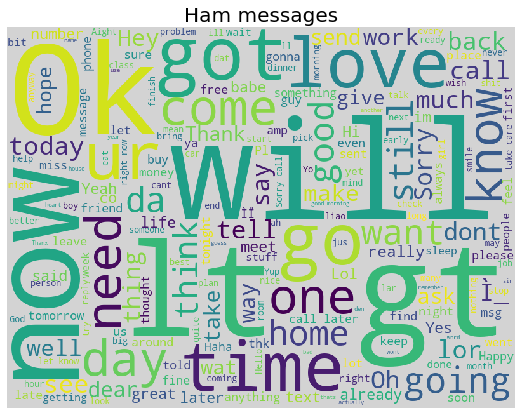

In [18]:
show_wordcloud(data_ham, "Ham messages")

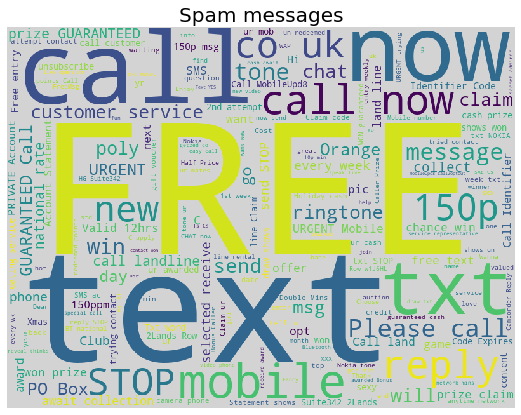

In [19]:
show_wordcloud(data_spam, "Spam messages")

## Part 2: Preprocessing

Basic preprocessing for common NLP tasks includes converting text to lowercase and removing punctuation and stopwords.
Further steps, especially for text classification tasks, are:

* Tokenization
* Vectorization and
* TF-IDF weighting
Lets apply these approaches on the SMS messages.


## 2.1 Remove Punctuation and Stopwords

Punctuation
We use the punctuation list from the string library:

In [20]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

## Stopwords
from sklearn documentation: https://scikit-learn.org/stable/modules/feature_extraction.html#stop-words
Stop words are words like “and”, “the”, “him”, which are presumed to be uninformative in representing the content of a text,
and which may be removed to avoid them being construed as signal for prediction.
Sometimes, however, similar words are useful for prediction, such as in classifying writing style or personality.

Due to the known issues in the ’english’ stop word list of sklearn, we use the stopwords from NLTK:

NLTK

In [21]:
from nltk.corpus import stopwords
stopwords.words("english")[100:110]

['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']

With the above lists for punctuation characters and stop words, we define a function to remove these from the text.
This function also converts all text to lowercase

In [22]:
def remove_punctuation_and_stopwords(sms):
    
    sms_no_punctuation = [ch for ch in sms if ch not in string.punctuation]
    sms_no_punctuation = "".join(sms_no_punctuation).split()
    
    sms_no_punctuation_no_stopwords = \
        [word.lower() for word in sms_no_punctuation if word.lower() not in stopwords.words("english")]
        
    return sms_no_punctuation_no_stopwords

In [23]:
data['text'].apply(remove_punctuation_and_stopwords).head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: text, dtype: object

## 2.2 Top 30 words in ham and spam messages



## 2.2.1 Collections: Counter¶

In [24]:
from collections import Counter

In [25]:
data_ham.loc[:, 'text'] = data_ham['text'].apply(remove_punctuation_and_stopwords)
words_data_ham = data_ham['text'].tolist()

data_spam.loc[:, 'text'] = data_spam['text'].apply(remove_punctuation_and_stopwords)
words_data_spam = data_spam['text'].tolist()

In [25]:
list_ham_words = []
for sublist in words_data_ham:
    for item in sublist:
        list_ham_words.append(item)

In [26]:
list_spam_words = []
for sublist in words_data_spam:
    for item in sublist:
        list_spam_words.append(item)

In [27]:
c_ham  = Counter(list_ham_words)
c_spam = Counter(list_spam_words)
df_hamwords_top30  = pd.DataFrame(c_ham.most_common(30),  columns=['word', 'count'])
df_spamwords_top30 = pd.DataFrame(c_spam.most_common(30), columns=['word', 'count'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

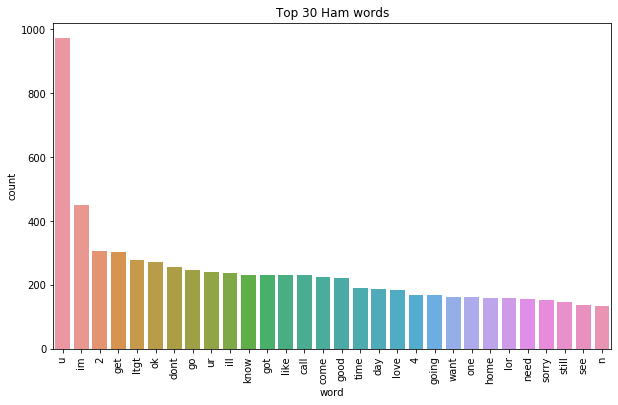

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_hamwords_top30, ax=ax)
plt.title("Top 30 Ham words")
plt.xticks(rotation='vertical')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

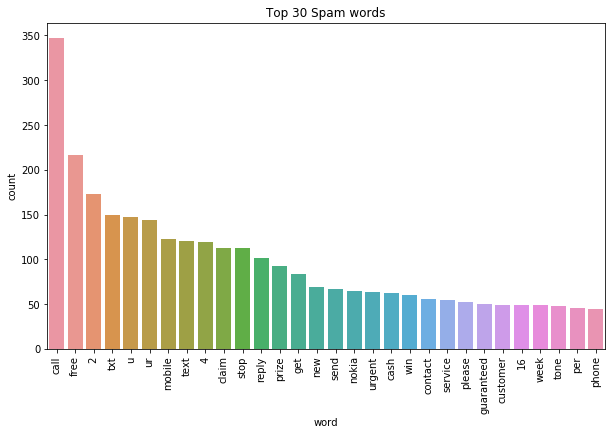

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_spamwords_top30, ax=ax)
plt.title("Top 30 Spam words")
plt.xticks(rotation='vertical')

## 2.2.2 NLTK: FreqDist

In [30]:
fdist_ham  = nltk.FreqDist(list_ham_words)
fdist_spam = nltk.FreqDist(list_spam_words)

In [31]:
df_hamwords_top30_nltk  = pd.DataFrame(fdist_ham.most_common(30),  columns=['word', 'count'])
df_spamwords_top30_nltk = pd.DataFrame(fdist_spam.most_common(30), columns=['word', 'count'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

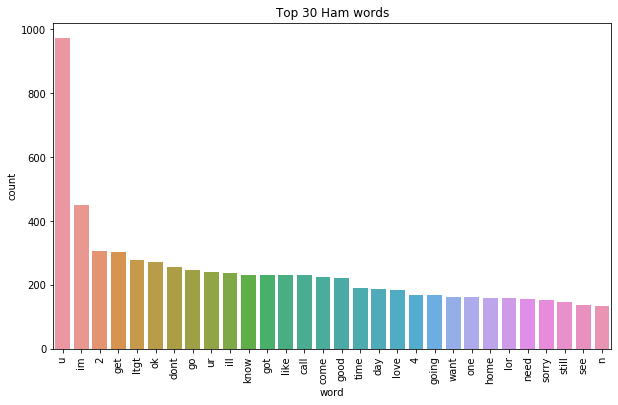

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_hamwords_top30_nltk, ax=ax)
plt.title("Top 30 Ham words")
plt.xticks(rotation='vertical')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

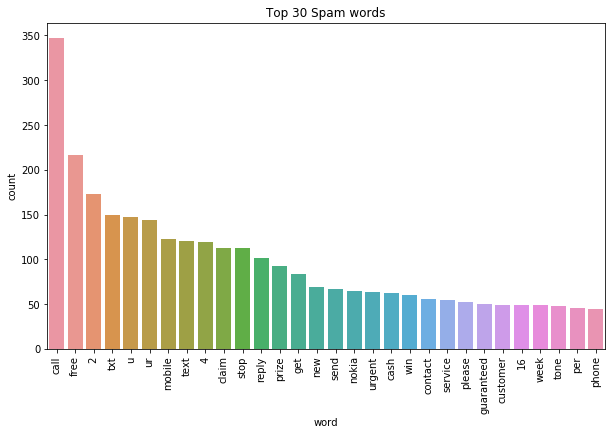

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_spamwords_top30_nltk, ax=ax)
plt.title("Top 30 Spam words")
plt.xticks(rotation='vertical')

## 2.2 Bag of words with CountVectorizer


The Bag of Words representation
https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.
In order to address this, scikit-learn provides utilities for the most common ways to extract numerical features from text content, namely:

* Tokenization

  tokenizing strings and giving an integer id for each possible token, for instance by using white-spaces and punctuation as   token separators.
* Vectorization

  counting the occurrences of tokens in each document.
* TF-IDF

  normalizing and weighting with diminishing importance tokens that occur in the majority of samples / documents.

* Bag of Words

  In this scheme, features and samples are defined as follows: each individual token occurrence frequency (normalized or not) is treated as a feature.
  
The vector of all the token frequencies for a given document is considered a multivariate sample.
A corpus of documents can thus be represented by a matrix with one row per document and one column per token (e.g. word) occurring in the corpus.
We call vectorization the general process of turning a collection of text documents into numerical feature vectors.
This specific strategy (tokenization, counting and normalization) is called the Bag of Words or “Bag of n-grams” representation.
Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

For futher details and example implementations see:
https://en.wikipedia.org/wiki/Bag-of-words_model
https://en.wikipedia.org/wiki/Document-term_matrix

An Introduction to Bag-of-Words in NLP
https://medium.com/greyatom/an-introduction-to-bag-of-words-in-nlp-ac967d43b428

In this kernel we apply the CountVectorizer from sklearn as BOW model.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
As tokenizer we use the remove_punctuation_and_stopwords function defined above

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer = remove_punctuation_and_stopwords).fit(data['text'])

In [35]:
print(len(bow_transformer.vocabulary_))

9431


In all sms messages bow_transformer counted 9431 different words.

## Examples for spam and ham messages

Lets look at some vectorization examples for spam and ham messages

In [36]:
sample_spam = data['text'][8]
bow_sample_spam = bow_transformer.transform([sample_spam])
print(sample_spam)
print(bow_sample_spam)

WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
  (0, 218)	1
  (0, 323)	1
  (0, 1906)	1
  (0, 2184)	2
  (0, 2245)	1
  (0, 2531)	1
  (0, 4194)	1
  (0, 4759)	1
  (0, 5707)	1
  (0, 6538)	1
  (0, 6775)	1
  (0, 6946)	1
  (0, 7209)	1
  (0, 8694)	1
  (0, 8698)	1
  (0, 9028)	1
  (0, 9418)	1


In [37]:
rows, cols = bow_sample_spam.nonzero()
for col in cols: 
    print(bow_transformer.get_feature_names()[col])

09061701461
12
call
claim
code
customer
hours
kl341
network
prize
receivea
reward
selected
valid
valued
winner
å£900


In [38]:
print(np.shape(bow_sample_spam))

(1, 9431)


In [39]:
sample_ham = data['text'][4]
bow_sample_ham = bow_transformer.transform([sample_ham])
print(sample_ham)
print(bow_sample_ham)

Nah I don't think he goes to usf, he lives around here though
  (0, 1279)	1
  (0, 2882)	1
  (0, 3762)	1
  (0, 5004)	1
  (0, 5631)	1
  (0, 8224)	1
  (0, 8243)	1
  (0, 8664)	1


In [40]:
rows, cols = bow_sample_ham.nonzero()
for col in cols: 
    print(bow_transformer.get_feature_names()[col])

around
dont
goes
lives
nah
think
though
usf


## Applying bow_transformer on all messages

In [41]:
bow_data = bow_transformer.transform(data['text'])

In [42]:
bow_data.shape

(5572, 9431)

In [43]:
bow_data.nnz

49772

## Sparsity: percentage of none zero entries

https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction


## Sparsity
As most documents will typically use a very small subset of the words used in the corpus,
the resulting matrix will have many feature values that are zeros (typically more than 99% of them).
For instance a collection of 10,000 short text documents (such as emails) will use a vocabulary
with a size in the order of 100,000 unique words in total while each document will use 100 to
1000 unique words individually.
In order to be able to store such a matrix in memory but also to speed up algebraic operations matrix / vector,
implementations will typically use a sparse representation such as available in the scipy.sparse package.

In [44]:
bow_data

<5572x9431 sparse matrix of type '<class 'numpy.int64'>'
	with 49772 stored elements in Compressed Sparse Row format>

In [45]:
bow_data.shape[0]

5572

In [46]:
bow_data.shape[1]

9431

In [47]:
bow_data.nnz

49772

In [48]:
print( bow_data.nnz / (bow_data.shape[0] * bow_data.shape[1]) *100 )

0.09471444959776236


Around 10% of the matrix are non zeros (=ones)

## 2.3 Term frequency inverse document frequency - TFIDF


## From occurrences to frequencies
https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#from-occurrences-to-frequencies

Occurrence count is a good start but there is an issue: longer documents will have higher average count values
than shorter documents, even though they might talk about the same topics.
To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document
by the total number of words in the document: these new features are called tf for Term Frequencies.
Another refinement on top of tf is to downscale weights for words that occur in many documents in the corpus and are
therefore less informative than those that occur only in a smaller portion of the corpus.
This downscaling is called tf–idf for “Term Frequency times Inverse Document Frequency”.

For futher details and example implementations see:
https://en.wikipedia.org/wiki/Tf%E2%80%93idf

https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments

TfidfTransformer from sklearn
Both tf and tf–idf can be computed as follows using TfidfTransformer:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

In [49]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(bow_data)

In [50]:
tfidf_sample_ham = tfidf_transformer.transform(bow_sample_ham)
print(tfidf_sample_ham)

  (0, 8664)	0.4000611457714059
  (0, 8243)	0.35462891367407595
  (0, 8224)	0.2665748147939407
  (0, 5631)	0.40493594386802356
  (0, 5004)	0.44910913790937335
  (0, 3762)	0.35674330934716636
  (0, 2882)	0.23016324066220836
  (0, 1279)	0.31179198007951625


In [51]:
tfidf_sample_spam = tfidf_transformer.transform(bow_sample_spam)
print(tfidf_sample_spam)

  (0, 9418)	0.2604683359422661
  (0, 9028)	0.23445094204464131
  (0, 8698)	0.24115248419490207
  (0, 8694)	0.22254833340975305
  (0, 7209)	0.2148462495005997
  (0, 6946)	0.2564029044370425
  (0, 6775)	0.2943229069695555
  (0, 6538)	0.178899142428953
  (0, 5707)	0.2148462495005997
  (0, 4759)	0.2943229069695555
  (0, 4194)	0.22555164191980467
  (0, 2531)	0.1915015107445745
  (0, 2245)	0.21371446699888028
  (0, 2184)	0.3406301232141347
  (0, 1906)	0.1153380143353214
  (0, 323)	0.2387711073538672
  (0, 218)	0.2943229069695555


In [52]:
data_tfidf = tfidf_transformer.transform(bow_data)


In [53]:
data_tfidf

<5572x9431 sparse matrix of type '<class 'numpy.float64'>'
	with 49772 stored elements in Compressed Sparse Row format>

In [54]:
np.shape(data_tfidf)

(5572, 9431)

## train test split

for TFIDF matrix only

In [55]:
from sklearn.model_selection import train_test_split

data_tfidf_train, data_tfidf_test, label_train, label_test = \
    train_test_split(data_tfidf, data["spam"], test_size=0.3, random_state=5)

In [56]:
data_tfidf_train

<3900x9431 sparse matrix of type '<class 'numpy.float64'>'
	with 35125 stored elements in Compressed Sparse Row format>

In [57]:
data_tfidf_test

<1672x9431 sparse matrix of type '<class 'numpy.float64'>'
	with 14647 stored elements in Compressed Sparse Row format>

for TFIDF matrix and feature "length"

In [58]:
from scipy.sparse import  hstack
X2 = hstack((data_tfidf ,np.array(data['length'])[:,None])).A

In [59]:
X2_train, X2_test, y2_train, y2_test = \
    train_test_split(X2, data["spam"], test_size=0.3, random_state=5)

## Part 3: Classifiers

## 3.1 First test for Classification


## Naive Bayes Classifier

sparse matrix to matrix

In [60]:
data_tfidf_train = data_tfidf_train.A
data_tfidf_test = data_tfidf_test.A

MNB Model using only TFIDF matrix

In [61]:
spam_detect_model = MultinomialNB().fit(data_tfidf_train, label_train)
pred_test_MNB = spam_detect_model.predict(data_tfidf_test)
acc_MNB = accuracy_score(label_test, pred_test_MNB)
print(acc_MNB)

0.965311004784689


Our first classifier seems to work well, it has an accuracy of 96.5 % for the test set.

In [62]:
scaler = MinMaxScaler()
data_tfidf_train_sc = scaler.fit_transform(data_tfidf_train)
data_tfidf_test_sc  = scaler.transform(data_tfidf_test)

MNB Model using only TFIDF matrix, scaled

In [63]:
spam_detect_model_minmax = MultinomialNB().fit(data_tfidf_train_sc, label_train)
pred_test_MNB = spam_detect_model_minmax.predict(data_tfidf_test_sc)
acc_MNB = accuracy_score(label_test, pred_test_MNB)
print(acc_MNB)

0.9826555023923444


Applying the min max scaler on the TFIDF matrix improves the performance of the MNB classifier:
It now has an accuracy of 98.2 % for the test set.

MNB model with TFIDF matrix and feature "length", unscaled

In [64]:
spam_detect_model_2 = MultinomialNB().fit(X2_train, y2_train)
pred_test_MNB_2 = spam_detect_model_2.predict(X2_test)
acc_MNB_2 = accuracy_score(y2_test, pred_test_MNB_2)
print(acc_MNB_2)

0.8761961722488039


Fitting MNB with the unscaled features TFIDF + length of message decreases performance.
Lets now check the fit with the scaled features.

In [65]:
X2_tfidf_train = X2_train[:,0:9431]
X2_tfidf_test  = X2_test[:,0:9431]
X2_length_train = X2_train[:,9431]
X2_length_test  = X2_test[:,9431]

In [66]:
scaler = MinMaxScaler()
X2_tfidf_train = scaler.fit_transform(X2_tfidf_train)
X2_tfidf_test  = scaler.transform(X2_tfidf_test)

In [67]:
scaler = MinMaxScaler()
X2_length_train = scaler.fit_transform(X2_length_train.reshape(-1, 1))
X2_length_test  = scaler.transform(X2_length_test.reshape(-1, 1))

In [68]:
X2_train = np.hstack((X2_tfidf_train, X2_length_train))
X2_test  = np.hstack((X2_tfidf_test,  X2_length_test))

MNB model with TFIDF matrix and feature "length", scaled



In [69]:
spam_detect_model_3 = MultinomialNB().fit(X2_train, y2_train)
pred_test_MNB_3 = spam_detect_model_3.predict(X2_test)
acc_MNB_3 = accuracy_score(y2_test, pred_test_MNB_3)
print(acc_MNB_3)

0.9826555023923444


## KNN

In [70]:
parameters_KNN = {'n_neighbors': (10,15,17), }

grid_KNN = GridSearchCV( KNeighborsClassifier(), parameters_KNN, cv=5,
                        n_jobs=-1, verbose=1)

grid_KNN.fit(data_tfidf_train, label_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  5.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1, param_grid={'n_neighbors': (10, 15, 17)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [71]:
print(grid_KNN.best_params_)
print(grid_KNN.best_score_)

{'n_neighbors': 15}
0.9364102564102564


In [72]:
parameters_KNN = {'n_neighbors': (6,8,10), }
grid_KNN = GridSearchCV( KNeighborsClassifier(), parameters_KNN, cv=5,
                        n_jobs=-1, verbose=1)
grid_KNN.fit(data_tfidf_train_sc, label_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  5.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1, param_grid={'n_neighbors': (6, 8, 10)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [73]:
print(grid_KNN.best_params_)
print(grid_KNN.best_score_)

{'n_neighbors': 6}
0.8743589743589744


## 3.2 train test split

for text data

In [74]:
from sklearn.model_selection import train_test_split

sms_train, sms_test, label_train, label_test = \
    train_test_split(data["text"], data["spam"], test_size=0.3, random_state=5)

In [75]:
sms_train.head()

3507    Camera quite good, 10.1mega pixels, 3optical a...
1332            It's ok lar. U sleep early too... Nite...
4259        Are you plans with your family set in stone ?
1236                             How much are we getting?
2132    Your B4U voucher w/c 27/03 is MARSMS. Log onto...
Name: text, dtype: object

## 3.3 Classification Pipelines


After splitting the data into a train and test set we now use a pipeline to apply the
CountVectorizer and the TfidfTransformer on both sets.
We also add a classifier to the pipeline, so we can combine all necessary steps in one object:

* Preprecocessing
* Crossvalidation (GridsearchCV)
* Fitting
* Predicting
* Evaluating (test score)

## 3.3.1 MultinomialNB


simple Pipeline. no optimization

In [76]:
pipe_MNB = Pipeline([ ('bow'  , CountVectorizer(analyzer = remove_punctuation_and_stopwords) ),
                   ('tfidf'   , TfidfTransformer()),
                   ('clf_MNB' , MultinomialNB()),
                    ])

test score

In [77]:
pipe_MNB.fit(X=sms_train, y=label_train)
pred_test_MNB = pipe_MNB.predict(sms_test)
acc_MNB = accuracy_score(label_test, pred_test_MNB)
print(acc_MNB)
print(pipe_MNB.score(sms_test, label_test))

0.9665071770334929
0.9665071770334929


The two steps
## CountVectorizer and TfidfTransformer
can also be performed in one step with
TfidfVectorizer
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
Convert a collection of raw documents to a matrix of TF-IDF features
Equivalent to CountVectorizer followed by TfidfTransformer.

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [79]:
pipe_MNB_tfidfvec = Pipeline([ ('tfidf_vec' , TfidfVectorizer(analyzer = remove_punctuation_and_stopwords)),
                               ('clf_MNB'   , MultinomialNB()),
                            ])

In [80]:
pipe_MNB_tfidfvec.fit(X=sms_train, y=label_train)
pred_test_MNB_tfidfvec = pipe_MNB_tfidfvec.predict(sms_test)
acc_MNB_tfidfvec = accuracy_score(label_test, pred_test_MNB_tfidfvec)
print(acc_MNB_tfidfvec)
print(pipe_MNB_tfidfvec.score(sms_test, label_test))

0.9665071770334929
0.9665071770334929


Yes, results are identical

## 3.3.2 KNN

Pipeline with GridSearchCV


optimize best model parameter: n_neighbors

In [81]:
pipe_KNN = Pipeline([ ('bow'  , CountVectorizer(analyzer = remove_punctuation_and_stopwords) ),
                   ('tfidf'   , TfidfTransformer()),
                   ('clf_KNN' , KNeighborsClassifier() )
                    ])

parameters_KNN = {'clf_KNN__n_neighbors': (8,15,20), }

grid_KNN = GridSearchCV(pipe_KNN, parameters_KNN, cv=5,
                        n_jobs=-1, verbose=1)

grid_KNN.fit(X=sms_train, y=label_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('bow',
                                        CountVectorizer(analyzer=<function remove_punctuation_and_stopwords at 0x0000026A85A68598>,
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_

best params

In [82]:
grid_KNN.best_params_

{'clf_KNN__n_neighbors': 15}

cross validation score: best score

In [83]:
grid_KNN.best_score_

0.936923076923077

test score

In [84]:
pred_test_grid_KNN = grid_KNN.predict(sms_test)
acc_KNN = accuracy_score(label_test, pred_test_grid_KNN)
print(acc_KNN)
print(grid_KNN.score(sms_test, label_test))

0.9515550239234449
0.9515550239234449


## 3.3.3 SVC

Pipeline with GridSearchCV

search best preprocessing: apply TfidfTransformer (yes/no)

In [85]:
pipe_SVC = Pipeline([ ('bow'  , CountVectorizer(analyzer = remove_punctuation_and_stopwords) ),
                   ('tfidf'   , TfidfTransformer()),
                   ('clf_SVC' , SVC(gamma='auto', C=1000)),
                    ])


parameters_SVC = dict(tfidf=[None, TfidfTransformer()],
                      clf_SVC__C=[500, 1000,1500]
                      )
#parameters = {'tfidf__use_idf': (True, False),    }

grid_SVC = GridSearchCV(pipe_SVC, parameters_SVC, 
                        cv=5, n_jobs=-1, verbose=1)

grid_SVC.fit(X=sms_train, y=label_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('bow',
                                        CountVectorizer(analyzer=<function remove_punctuation_and_stopwords at 0x0000026A85A68598>,
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_

In [86]:
grid_SVC.best_params_

{'clf_SVC__C': 1500, 'tfidf': None}

In [87]:
grid_SVC.best_score_

0.9761538461538461

In [88]:
pred_test_grid_SVC = grid_SVC.predict(sms_test)
acc_SVC = accuracy_score(label_test, pred_test_grid_SVC)
print(acc_SVC)
print(grid_SVC.score(sms_test, label_test))

0.9838516746411483
0.9838516746411483


## 3.3.4 SGD

Pipeline with GridSearch

search best preprocessing: use_idf (yes/no)
    
and best model parameters (alpha, penalty)

In [89]:
pipe_SGD = Pipeline([ ('bow'  , CountVectorizer(analyzer = remove_punctuation_and_stopwords) ),
                   ('tfidf'   , TfidfTransformer()),
                   ('clf_SGD' , SGDClassifier(random_state=5)),
                    ])

parameters_SGD = {
    #'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf_SGD__max_iter': (5,10),
    'clf_SGD__alpha': (1e-05, 1e-04),
}

grid_SGD = GridSearchCV(pipe_SGD, parameters_SGD, cv=5,
                               n_jobs=-1, verbose=1)

grid_SGD.fit(X=sms_train, y=label_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('bow',
                                        CountVectorizer(analyzer=<function remove_punctuation_and_stopwords at 0x0000026A85A68598>,
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_

In [90]:
grid_SGD.best_params_

{'clf_SGD__alpha': 0.0001, 'tfidf__use_idf': True}

In [91]:
grid_SGD.best_score_

0.9766666666666667

In [92]:
pred_test_grid_SGD = grid_SGD.predict(sms_test)
acc_SGD = accuracy_score(label_test, pred_test_grid_SGD)
print(acc_SGD)
print(grid_SGD.score(sms_test, label_test))

0.9880382775119617
0.9880382775119617


## 3.3.5 GradientBoostingClassifier

In [93]:
pipe_GBC = Pipeline([ ('bow'  , CountVectorizer(analyzer = remove_punctuation_and_stopwords) ),
                      ('tfidf'   , TfidfTransformer() ),
                      ('clf_GBC' , GradientBoostingClassifier(random_state=5) ),
                    ])

parameters_GBC = { 'tfidf__use_idf': (True, False), 
                   'clf_GBC__learning_rate': (0.1, 0.2),
                   #'clf_GBC__min_samples_split': (3,5), 
                 }

grid_GBC = GridSearchCV(pipe_GBC, parameters_GBC, 
                        cv=5, n_jobs=-1, verbose=1)

grid_GBC.fit(X=sms_train, y=label_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('bow',
                                        CountVectorizer(analyzer=<function remove_punctuation_and_stopwords at 0x0000026A85A68598>,
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_

In [94]:
grid_GBC.best_params_

{'clf_GBC__learning_rate': 0.2, 'tfidf__use_idf': False}

In [95]:
grid_GBC.best_score_

0.9641025641025641

In [96]:
pred_test_grid_GBC = grid_GBC.predict(sms_test)
acc_GBC = accuracy_score(label_test, pred_test_grid_GBC)
print(acc_GBC)
print(grid_GBC.score(sms_test, label_test))

0.9736842105263158
0.9736842105263158


## 3.3.6 XGBoost Classifier

In [101]:
import xgboost as xgb

In [102]:
pipe_XGB = Pipeline([ ('bow'  , CountVectorizer(analyzer = remove_punctuation_and_stopwords) ),
                      ('tfidf'   , TfidfTransformer() ),
                      ('clf_XGB' , xgb.XGBClassifier(random_state=5) ),
                    ])

parameters_XGB = { 'tfidf__use_idf': (True, False), 
                   'clf_XGB__eta': (0.01, 0.02),
                   'clf_XGB__max_depth': (5,6), 
                 }

grid_XGB = GridSearchCV(pipe_XGB, parameters_XGB, 
                        cv=5, n_jobs=-1, verbose=1)

grid_XGB.fit(X=sms_train, y=label_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 11.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('bow',
                                        CountVectorizer(analyzer=<function remove_punctuation_and_stopwords at 0x0000026A85A68598>,
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_

In [103]:
grid_XGB.best_params_

{'clf_XGB__eta': 0.01, 'clf_XGB__max_depth': 5, 'tfidf__use_idf': False}

In [104]:
grid_XGB.best_score_

0.958974358974359

In [105]:
pred_test_grid_XGB = grid_XGB.predict(sms_test)
acc_XGB = accuracy_score(label_test, pred_test_grid_XGB)
print(acc_XGB)
print(grid_XGB.score(sms_test, label_test))

0.9736842105263158
0.9736842105263158


## 3.4 Comparison of results

https://towardsdatascience.com/understanding-data-science-classification-metrics-in-scikit-learn-in-python-3bc336865019

https://scikit-learn.org/stable/modules/model_evaluation.html

In [106]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score

For a binary classification task, there are 4 possible results:

TN: True negatives (ham mails labeled as ham)
    
FP: False positives (ham mails labeled as spam)
    
FN: False negatives (spam mails labeled as ham)
    
TP: True positives (spam mails labeled as spam)
    
## confusion_matrix
The confusion matrix gives an overview of the classification results:

The diagonal elements represent the number of points for which the predicted label is equal to the true label,
while off-diagonal elements are those that are mislabeled by the classifier.

The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

The rows of a confusion matrix correspond to the true (actual) classes and the columns correspond to the predicted classes.
So, all together the confusion matrix for a binary classifier consists of 4 values:

TN FP

FN TP

Using seaborn heat map for nice plot of confusion matrix

In [107]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    #fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  
                cmap="Blues", square=True, cbar=False)
    #  
    plt.ylabel('true label')
    plt.xlabel('predicted label')

Dictionary of predictions

In [108]:
list_clf = ["MNB", "KNN", "SVC", "SGD", "GBC", "XGB"]

list_pred = [pred_test_MNB, pred_test_grid_KNN, 
             pred_test_grid_SVC, pred_test_grid_SGD,
             pred_test_grid_GBC, pred_test_grid_XGB]

dict_pred = dict(zip(list_clf, list_pred))

In [109]:
def plot_all_confusion_matrices(y_true, dict_all_pred, str_title):
    
    list_classifiers = list(dict_all_pred.keys())
    plt.figure(figsize=(10,7.5))
    plt.suptitle(str_title, fontsize=20, fontweight='bold')
    n=231

    for clf in list_classifiers : 
        plt.subplot(n)
        plot_confusion_matrix(y_true, dict_all_pred[clf])
        plt.title(clf, fontweight='bold')
        n+=1

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

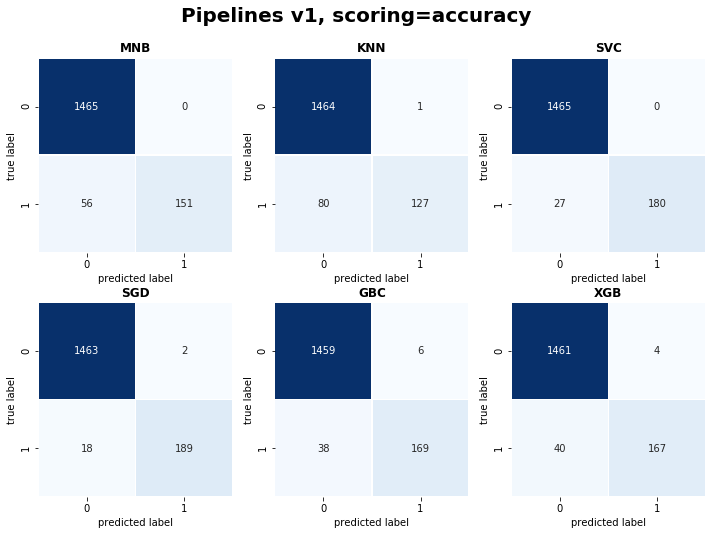

In [110]:
plot_all_confusion_matrices(label_test, dict_pred, "Pipelines v1, scoring=accuracy")

## accuracy_score

classification accuracy = correct predictions / total predictions = (TP + TN) / (TP + TN + FP + FN)

In [111]:
dict_acc = {}
for clf in list_clf :
    dict_acc[clf] = accuracy_score(label_test, dict_pred[clf])

In [112]:
for clf in list_clf :
    print(clf, " " , dict_acc[clf])

MNB   0.9665071770334929
KNN   0.9515550239234449
SVC   0.9838516746411483
SGD   0.9880382775119617
GBC   0.9736842105263158
XGB   0.9736842105263158


Comparing the accuracy_score with the confusion matrices, one finds that
accuracy score may not be the best parameter to choose the best classifier.
SGD, a model with high accuracy_score, incorrectly classifies 6 ham mails as spam,
which is usually not wanted for a spam classifier (important mails might get lost).
MNB has less accuracy than SGD, but it classifies all ham mails correctly.
SVC also classifies all ham mails correctly but compared to MNB it classifies
much more spam mails correctly.
Apart from accuracy there are further scoring methods to evaluate a classifier.
Lets look at the other classifier scores in more detail:
precision, recall, fscore, support, roc_auc

## precision_score

The precision is the ratio TP / (TP + FP) where TP is the number of true positives and TP the number of false positives.

The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
Precision = 1 for FP = 0 and precision goes up when FP goes down.

In [113]:
for clf in list_clf :
    print(clf, " ", precision_score(label_test, dict_pred[clf]))

MNB   1.0
KNN   0.9921875
SVC   1.0
SGD   0.9895287958115183
GBC   0.9657142857142857
XGB   0.9766081871345029


By definition the precision is calculated for the negative class (label = 0, ham mails).
This is also the default when calling precision score without any further parameters.
But we can also examine the precision for the individual labels (ham,spam = 0,1)

In [114]:
for clf in list_clf :
    print(clf, " ", precision_score(label_test, dict_pred[clf], average=None, labels=[0,1]))

MNB   [0.96318212 1.        ]
KNN   [0.94818653 0.9921875 ]
SVC   [0.98190349 1.        ]
SGD   [0.98784605 0.9895288 ]
GBC   [0.9746159  0.96571429]
XGB   [0.9733511  0.97660819]


Precision for classifying ham mails is 1.0 for the MNB and SVC classifier.
SGD has the best precision for classifying ham mails.

## recall_score
The recall is the ratio TP / (TP + FN) where TP is the number of true positives and FN the number of false negatives.
The recall is intuitively the ability of the classifier to find all the positive samples.

In [115]:
for clf in list_clf :
    print(clf, " ", recall_score(label_test, dict_pred[clf]))

MNB   0.7294685990338164
KNN   0.6135265700483091
SVC   0.8695652173913043
SGD   0.9130434782608695
GBC   0.8164251207729468
XGB   0.8067632850241546


Recall is defined regarding the positive class (label=1, spam mails).
Again, if we call the recall score method with the labels parameter, we get
the recall for ham and spam messages:

In [116]:
for clf in list_clf :
    print(clf, " ", recall_score(label_test, dict_pred[clf], average=None, labels=[0,1] ))

MNB   [1.        0.7294686]
KNN   [0.99931741 0.61352657]
SVC   [1.         0.86956522]
SGD   [0.99863481 0.91304348]
GBC   [0.99590444 0.81642512]
XGB   [0.99726962 0.80676329]


## f1_score

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall,
where an F-beta score reaches its best value at 1 and worst score at 0.
The F-beta score weights recall more than precision by a factor of beta.
beta == 1.0 means recall and precision are equally important.

In [117]:
for clf in list_clf :
    print(clf, " ", f1_score(label_test, dict_pred[clf]))

MNB   0.8435754189944134
KNN   0.7582089552238805
SVC   0.9302325581395349
SGD   0.949748743718593
GBC   0.8848167539267014
XGB   0.8835978835978836


In [118]:
for clf in list_clf :
    print(clf, " ", f1_score(label_test, dict_pred[clf], average=None, labels=[0,1] ))

MNB   [0.98124581 0.84357542]
KNN   [0.97308076 0.75820896]
SVC   [0.99086912 0.93023256]
SGD   [0.99321113 0.94974874]
GBC   [0.98514517 0.88481675]
XGB   [0.98516521 0.88359788]


## classification_report

In [119]:
print(classification_report(label_test, pred_test_MNB))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1465
           1       1.00      0.73      0.84       207

    accuracy                           0.97      1672
   macro avg       0.98      0.86      0.91      1672
weighted avg       0.97      0.97      0.96      1672



precision_recall_fscore_support

In [120]:
for clf in list_clf :
    print(clf, " ", precision_recall_fscore_support(label_test, dict_pred[clf], average=None, labels=[0,1] ))

MNB   (array([0.96318212, 1.        ]), array([1.       , 0.7294686]), array([0.98124581, 0.84357542]), array([1465,  207], dtype=int64))
KNN   (array([0.94818653, 0.9921875 ]), array([0.99931741, 0.61352657]), array([0.97308076, 0.75820896]), array([1465,  207], dtype=int64))
SVC   (array([0.98190349, 1.        ]), array([1.        , 0.86956522]), array([0.99086912, 0.93023256]), array([1465,  207], dtype=int64))
SGD   (array([0.98784605, 0.9895288 ]), array([0.99863481, 0.91304348]), array([0.99321113, 0.94974874]), array([1465,  207], dtype=int64))
GBC   (array([0.9746159 , 0.96571429]), array([0.99590444, 0.81642512]), array([0.98514517, 0.88481675]), array([1465,  207], dtype=int64))
XGB   (array([0.9733511 , 0.97660819]), array([0.99726962, 0.80676329]), array([0.98516521, 0.88359788]), array([1465,  207], dtype=int64))


## roc_auc_score

In [121]:
for clf in list_clf :
    print(clf, " ", roc_auc_score(label_test, dict_pred[clf] ))

MNB   0.8647342995169083
KNN   0.806421988095827
SVC   0.9347826086956521
SGD   0.9558391452737794
GBC   0.9061647788165076
XGB   0.9020164547987667


In [122]:
import sklearn.metrics
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

## 3.5 Optimize classifiers with scoring by precision


We perform GridSearchCV again, using the same parameter grids and pipelines like before.

For all classifier pipelines, we only change the scoring method from "accuracy" to "precision".

In [123]:
scoring = 'precision'

## 3.5.1 GridSearchCV pipelines version 2

MNB

The precision for MNB was already 1.0 so it can not be improved.

KNN

In [124]:
grid_KNN_2 = GridSearchCV(pipe_KNN, parameters_KNN, cv=5,
                          scoring=scoring, n_jobs=-1, verbose=1)

grid_KNN_2.fit(X=sms_train, y=label_train)
pred_test_grid_KNN_2 = grid_KNN_2.predict(sms_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.5min finished


In [125]:
grid_KNN_2.best_params_

{'clf_KNN__n_neighbors': 8}

SVC

In [126]:
grid_SVC_2 = GridSearchCV(pipe_SVC, parameters_SVC, cv=5,
                          scoring=scoring, n_jobs=-1, verbose=1)

grid_SVC_2.fit(X=sms_train, y=label_train)
pred_test_grid_SVC_2 = grid_SVC_2.predict(sms_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.3min finished


SGD

In [127]:
grid_SGD_2 = GridSearchCV(pipe_SGD, parameters_SGD, cv=5,
                          scoring=scoring, n_jobs=-1, verbose=1)

grid_SGD_2.fit(X=sms_train, y=label_train)
pred_test_grid_SGD_2 = grid_SGD_2.predict(sms_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.2min finished


GBC

In [128]:
grid_GBC_2 = GridSearchCV(pipe_GBC, parameters_GBC, cv=5,
                          scoring=scoring, n_jobs=-1, verbose=1)

grid_GBC_2.fit(X=sms_train, y=label_train)
pred_test_grid_GBC_2 = grid_GBC_2.predict(sms_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.6min finished


XGB

In [129]:
grid_XGB_2 = GridSearchCV(pipe_XGB, parameters_XGB, cv=5,
                          scoring=scoring, n_jobs=-1, verbose=1)

grid_XGB_2.fit(X=sms_train, y=label_train)
pred_test_grid_XGB_2 = grid_XGB_2.predict(sms_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 10.0min finished


## 3.5.2 Confusion matrices for scoring by precision

In [130]:
list_clf = ["MNB", "KNN_2", "SVC_2", "SGD_2", "GBC_2", "XGB_2"]

list_pred = [pred_test_MNB, pred_test_grid_KNN_2, 
             pred_test_grid_SVC_2, pred_test_grid_SGD_2,
             pred_test_grid_GBC_2, pred_test_grid_XGB_2]

dict_pred_2 = dict(zip(list_clf, list_pred))

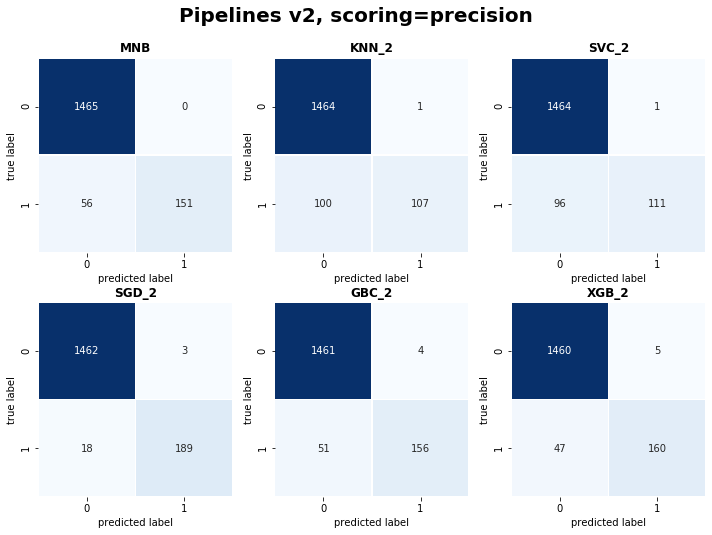

In [131]:
plot_all_confusion_matrices(label_test, dict_pred_2, "Pipelines v2, scoring=precision")

## 3.6 Optimize classifiers with scoring by recall

For spam detection optimizing tbe classifiers by precision seems most reasonable.
But for other tasks it may be advantageous to have a classifier with maximum recall.
For example, in Credit Card Fraud detections, you want to find all fraud samples.
For all classifier pipelines, we perform GridSearchCV again, using the same parameter grids
and only changing the scoring method to "recall".

In [132]:
scoring = 'recall'

## 3.6.1 GridSearchCV pipelines version 3

## KNN

In [133]:
grid_KNN_3 = GridSearchCV(pipe_KNN, parameters_KNN, cv=5,
                          scoring=scoring, n_jobs=-1, verbose=1)

grid_KNN_3.fit(X=sms_train, y=label_train)
pred_test_grid_KNN_3 = grid_KNN_3.predict(sms_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.7min finished


In [134]:
grid_KNN_3.best_params_

{'clf_KNN__n_neighbors': 15}

SVC

In [135]:
grid_SVC_3 = GridSearchCV(pipe_SVC, parameters_SVC, cv=5,
                          scoring=scoring, n_jobs=-1, verbose=1)

grid_SVC_3.fit(X=sms_train, y=label_train)
pred_test_grid_SVC_3 = grid_SVC_3.predict(sms_test)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.8min finished


SGD

In [136]:
grid_SGD_3 = GridSearchCV(pipe_SGD, parameters_SGD, cv=5,
                          scoring=scoring, n_jobs=-1, verbose=1)

grid_SGD_3.fit(X=sms_train, y=label_train)
pred_test_grid_SGD_3 = grid_SGD_3.predict(sms_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  5.1min finished


GBC

In [ ]:
grid_GBC_3 = GridSearchCV(pipe_GBC, parameters_GBC, cv=5,
                          scoring=scoring, n_jobs=-1, verbose=1)

grid_GBC_3.fit(X=sms_train, y=label_train)
pred_test_grid_GBC_3 = grid_GBC_3.predict(sms_test)

XGB

In [ ]:
grid_XGB_3 = GridSearchCV(pipe_XGB, parameters_XGB, cv=5,
                          scoring=scoring, n_jobs=-1, verbose=1)

grid_XGB_3.fit(X=sms_train, y=label_train)
pred_test_grid_XGB_3 = grid_XGB_3.predict(sms_test)

## 3.6.2 Confusion matrices for scoring by recall

In [ ]:
list_clf = ["MNB", "KNN_3", "SVC_3", "SGD_3", "GBC_3", "XGB_3"]

list_pred = [pred_test_MNB, pred_test_grid_KNN_3, 
             pred_test_grid_SVC_3, pred_test_grid_SGD_3,
             pred_test_grid_GBC_3, pred_test_grid_XGB_3]

dict_pred_3 = dict(zip(list_clf, list_pred))

In [ ]:
plot_all_confusion_matrices(label_test, dict_pred_3, "Pipelines v3, scoring=recall")

## 3.7 Optimize classifiers with scoring by roc_auc_score

In [ ]:
scoring = 'roc_auc'

## 3.7.1 GridSearchCV pipelines version 4


KNN

In [ ]:
grid_KNN_4 = GridSearchCV(pipe_KNN, parameters_KNN, cv=5,
                          scoring=scoring, n_jobs=-1, verbose=1)

grid_KNN_4.fit(X=sms_train, y=label_train)
pred_test_grid_KNN_4 = grid_KNN_4.predict(sms_test)

In [ ]:
grid_KNN_4.best_params_

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thr = roc_curve(label_test, grid_KNN_4.predict_proba(sms_test)[:,1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot')
auc_knn4 = auc(fpr, tpr) * 100
plt.legend(["AUC {0:.3f}".format(auc_knn4)])

SVC

In [ ]:
grid_SVC_4 = GridSearchCV(pipe_SVC, parameters_SVC, cv=5,
                          scoring=scoring, n_jobs=-1, verbose=1)

grid_SVC_4.fit(X=sms_train, y=label_train)
pred_test_grid_SVC_4 = grid_SVC_4.predict(sms_test)

SGD

In [ ]:
grid_SGD_4 = GridSearchCV(pipe_SGD, parameters_SGD, cv=5,
                          scoring=scoring, n_jobs=-1, verbose=1)

grid_SGD_4.fit(X=sms_train, y=label_train)
pred_test_grid_SGD_4 = grid_SGD_4.predict(sms_test)

GBC

In [ ]:
grid_GBC_4 = GridSearchCV(pipe_GBC, parameters_GBC, cv=5,
                          scoring=scoring, n_jobs=-1, verbose=1)

grid_GBC_4.fit(X=sms_train, y=label_train)
pred_test_grid_GBC_4 = grid_GBC_4.predict(sms_test)

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thr = roc_curve(label_test, grid_GBC_4.predict_proba(sms_test)[:,1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot')
auc_gbc4 = auc(fpr, tpr) * 100
plt.legend(["AUC {0:.3f}".format(auc_gbc4)])

XGB

In [ ]:
grid_XGB_4 = GridSearchCV(pipe_XGB, parameters_XGB, cv=5,
                          scoring=scoring, n_jobs=-1, verbose=1)

grid_XGB_4.fit(X=sms_train, y=label_train)
pred_test_grid_XGB_4 = grid_XGB_4.predict(sms_test)

## 3.7.2 Confusion matrices for scoring by roc auc

In [ ]:
list_clf = ["MNB", "KNN_4", "SVC_4", "SGD_4", "GBC_4", "XGB_4"]

list_pred = [pred_test_MNB, pred_test_grid_KNN_4, 
             pred_test_grid_SVC_4, pred_test_grid_SGD_4,
             pred_test_grid_GBC_4, pred_test_grid_XGB_4]

dict_pred_4 = dict(zip(list_clf, list_pred))

In [ ]:
plot_all_confusion_matrices(label_test, dict_pred_4, "Pipelines v4, scoring=roc auc")

## Part 4: NLTK

In [ ]:
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

In [ ]:
print(data['text'][7])

In [ ]:
print(sent_tokenize(data['text'][7]))

In [ ]:
print(word_tokenize(data['text'][7]))

In [ ]:
stopWords = set(stopwords.words('english'))
words = word_tokenize(data['text'][7])
wordsFiltered = []

for w in words:
    if w not in stopWords:
        wordsFiltered.append(w)

print(wordsFiltered)